In [191]:
# packages 로딩
import numpy as np
import pandas as pd            
import matplotlib.pyplot as plt # 시각화
import seaborn as sns           # 시각화 (matplotlib보다 빠르고 간단, 좀 더 다양한 색상)

from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler # 각 특성의 평균을 0, 분산을 1로 변경하여 특성의 스케일을 맞춤. 최솟값과 최댓값의 크기 제한X
from scipy import stats

import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc                       # Garbage Collector (메모리를 자동으로 관리해주는 '과정')

- scipy : 수치해석 기능을 제공하는
- scipy.stats : 확률분포 분석을 위한 다양한 기능 제공하는 sub package
- norm : 정규 분포

# 1.데이터 로드

In [192]:
df_train = pd.read_csv('Data2/train.csv')
df_test  = pd.read_csv('Data2/test.csv')

In [193]:
print("훈련 데이터 크기 : ",df_train.shape)
print("테스트 데이터 크기 : ",df_test.shape)

훈련 데이터 크기 :  (1751, 81)
테스트 데이터 크기 :  (1168, 80)


In [194]:
df_train.info() # 수치형데이터(타켓값 제외) : 37개 
                # 범주형데이터 : 43개

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1751 entries, 0 to 1750
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1751 non-null   int64  
 1   MSSubClass     1751 non-null   int64  
 2   MSZoning       1747 non-null   object 
 3   LotFrontage    1450 non-null   float64
 4   LotArea        1751 non-null   int64  
 5   Street         1751 non-null   object 
 6   Alley          125 non-null    object 
 7   LotShape       1751 non-null   object 
 8   LandContour    1751 non-null   object 
 9   Utilities      1750 non-null   object 
 10  LotConfig      1751 non-null   object 
 11  LandSlope      1751 non-null   object 
 12  Neighborhood   1751 non-null   object 
 13  Condition1     1751 non-null   object 
 14  Condition2     1751 non-null   object 
 15  BldgType       1751 non-null   object 
 16  HouseStyle     1751 non-null   object 
 17  OverallQual    1751 non-null   int64  
 18  OverallC

In [195]:
#df_test.info()

### 1) 시각화 : SalePrice(타켓값)

In [196]:
#타켓값(SalePrice) 통계 요약
df_train['SalePrice'].describe()

count      1751.000000
mean     179176.913237
std       78702.014153
min       34900.000000
25%      129000.000000
50%      159434.000000
75%      211413.386693
max      755000.000000
Name: SalePrice, dtype: float64

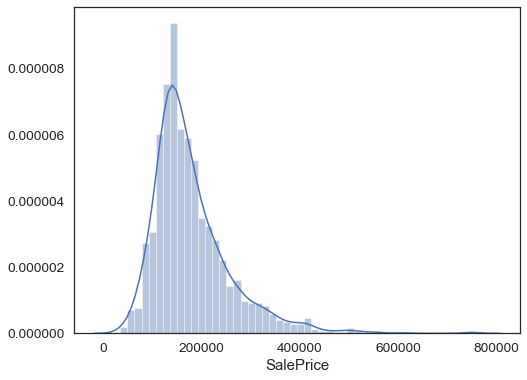

In [197]:
#타켓 값의 분포정도 확인 (histogram)
f, ax = plt.subplots(figsize=(8, 6))  #1개의축(ax)에 해당사이즈(8,6)으로 그래프 배치b
sns.distplot(df_train['SalePrice'])

오른쪽으로 꼬리가 길다! == 정적비대칭 ---> 정규화 해야 한다

In [198]:
#왜도와 첨도(skewness and kurtosis)

#왜도: 중심축을 기준으로 어느 한쪽으로 치우친 정도. 왜도가 0인경우 분포는 좌우대칭이 된다는 뜻 
#우측꼬리가 긴 정적비대칭과(일반적으로 평균>중앙값>..>최빈값), 좌측꼬리가 긴 부적비대칭이 있음(최빈값>..>중앙값>평균)

#첨도:정점의 x좌표는 같고 정점의 y좌표가 얼마나 높고 낮은가를 보여주는 척도 (얼마나 더 뾰족하고 뭉퉁스러운지 보여주는 척도)
#첨도의 값이 클수록 뾰족하다

In [199]:
print("왜도 값: %f" % df_train['SalePrice'].skew())
print("첨도 값: %f" % df_train['SalePrice'].kurt())

왜도 값: 1.798484
첨도 값: 5.683753


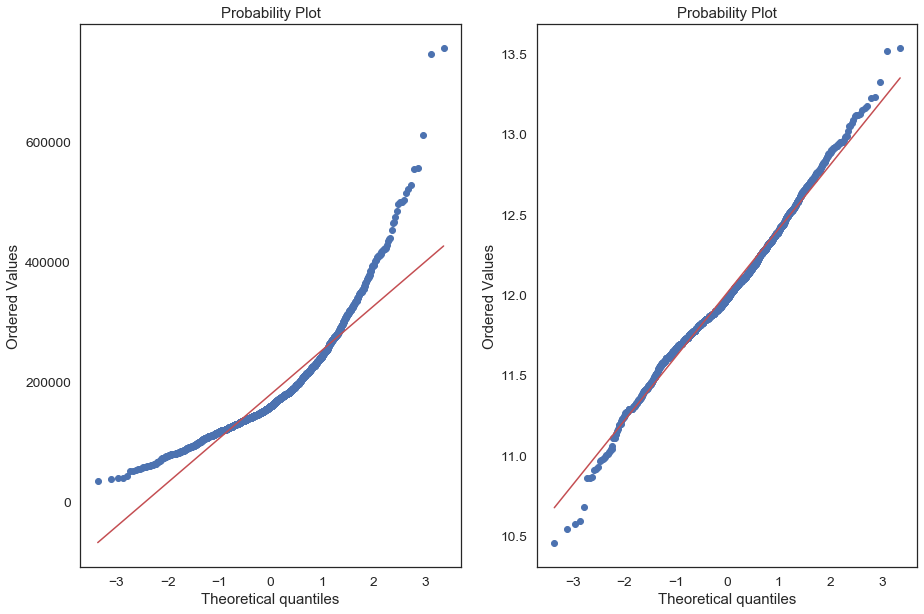

In [200]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(df_train['SalePrice'], plot=plt)  # 정규확률그림(Q-Q plot)을 그려주는 stats.probplot

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['SalePrice']), plot=plt)

In [201]:
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [202]:
df_train['SalePrice'].head()

0    12.310437
1    11.872354
2    12.305923
3    12.156203
4    12.100718
Name: SalePrice, dtype: float64

### 2) 타켓값과 상관 관계가 높은 변수 시각화

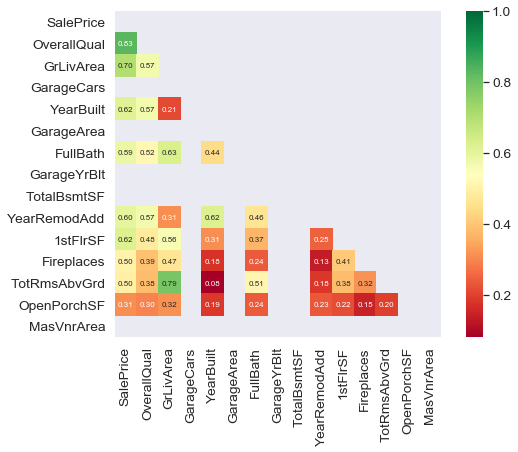

In [203]:
# 타켓값 상관 관계 매트릭스
corrmat = abs(df_train.corr(method='spearman')) # correlation 전체 변수에 대해서 계산
                                                # Spearman Rank Correlation : 두 메트릭스 또는 순차 변수간의 단순 관계를 평가해줌
cols = corrmat.nlargest(15, 'SalePrice').index  # nlargest : (상관관계높은순서대로 출력할갯수n, ''이특성기준으로 정렬).inex출력
cm = np.corrcoef(df_train[cols].values.T)       # 피어슨 상관계수 값을 구해주는 np.corrcoef()    
sns.set(font_scale = 1.25)                # 글씨 크기
f, ax = plt.subplots(figsize=(9, 6))     # 그래프 사이즈

mask = np.zeros_like(cm) 
mask[np.triu_indices_from(mask)] = True 
sns.set_style("white")
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',annot_kws={'size': 8}, yticklabels=cols.values, xticklabels=cols.values, mask = mask, cmap='RdYlGn')
plt.show()

SalePrice와 상관관계가 높은 9가지 특성
- OverallQual  (전체적 품질: 주택의 전체 자재 및 마감에 대한 평가)
- GrLivArea    (1등급 이상(지상) 거주 지역 평방 피트)
- GarageCars   (자동차 용량의 차고 크기)
- GarageArea   (평방 피트의 차고 크기)
- TotalBsmtSF  (지하실의 총 평방피트)
- 1stFlrSF     (1층 평방 피트)
- FullBath     (등급 이상의 전체 욕실)
- TotRmsAbvGrd (총 객실 등급 이상(화장실 포함 안 함))
- YearBuilt    (원래 시공 날짜)

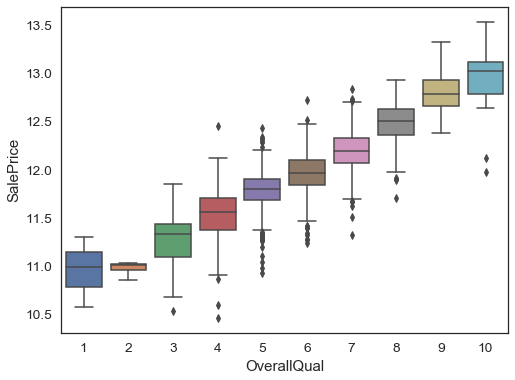

In [204]:
data = pd.concat([df_train['SalePrice'], df_train['OverallQual']], axis=1)  #concat((데이터1,데이터2),1이면열방향으로) 데이터 합치기
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='OverallQual', y="SalePrice", data=data)

- 전체적인 품질이 높아지진다 == 타켓값도 상승
- 3,4,7,10의 이상값은 다시 확인 필요

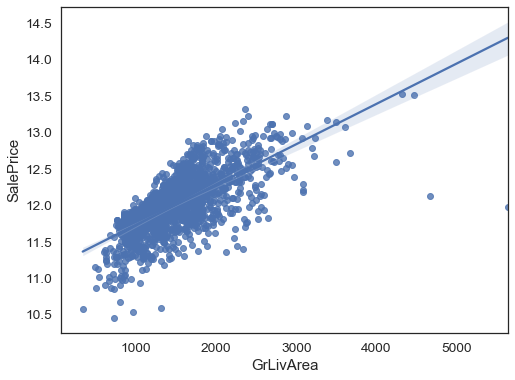

In [205]:
data = pd.concat([df_train['SalePrice'], df_train['GrLivArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='GrLivArea', y="SalePrice", data=data)

- GrLivArea와 타켓값 사이 == 양의 상관관계 ===> 즉 면적이 넓어진다? == 가격도 올라간다
- 그러나 오른쪽(GrLivArea>4000 && SalePrice<13.0)에 2개의 이상치 존재

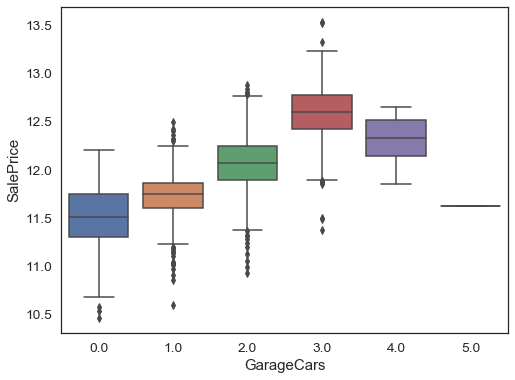

In [206]:
data = pd.concat([df_train['SalePrice'], df_train['GarageCars']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=data)

- GarageCars의 5가 이상한 형태를 보이고 있다! --> 왜일까? 데이터탐색필요

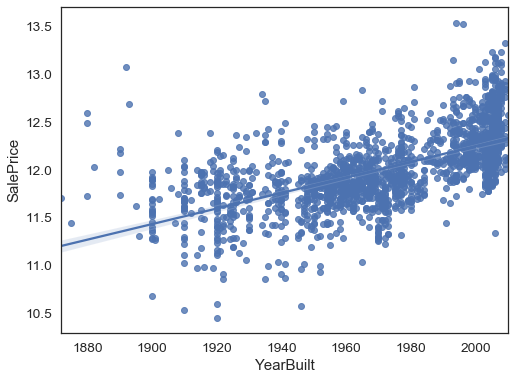

In [207]:
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='YearBuilt', y="SalePrice", data=data)

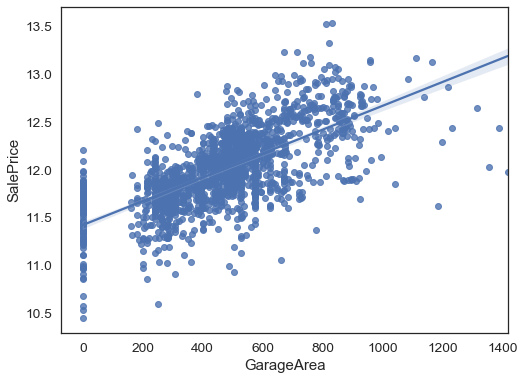

In [208]:
data = pd.concat([df_train['SalePrice'], df_train['GarageArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='GarageArea', y="SalePrice", data=data)

- GarageArea는 크게 0과 0이 아닌 부분으로 나뉘고 있다 -> 왜? 차고가 없는 집이 있기 때문
- 0이 아닌 부분은 일반적으로 양의 상관관계에 있다. 그러나 일부 이상치 존재.

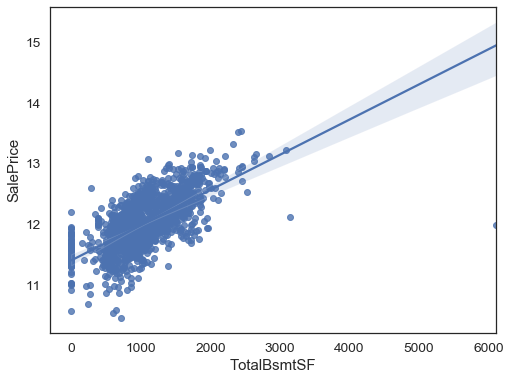

In [209]:
data = pd.concat([df_train['SalePrice'], df_train['TotalBsmtSF']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='TotalBsmtSF', y="SalePrice", data=data)

- 오른쪽(TotalBsmtSF>6000)에 이상치 존재

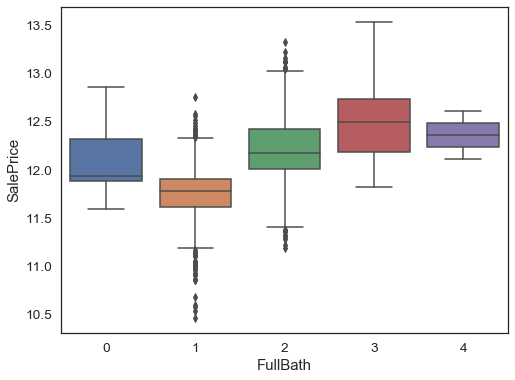

In [210]:
data = pd.concat([df_train['SalePrice'], df_train['FullBath']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='FullBath', y="SalePrice", data=data)

- 욕실(Bath)와 관련된 변수가 많기에 0보다 높은 값 존재 (HalfBath...)

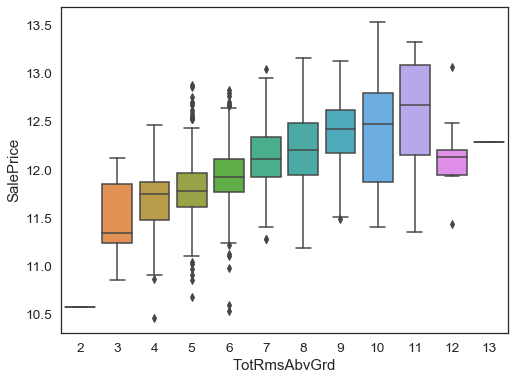

In [211]:
data = pd.concat([df_train['SalePrice'], df_train['TotRmsAbvGrd']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='TotRmsAbvGrd', y="SalePrice", data=data)

이상치..
- 12, 13
- 6에 매우 낮은 값 존재
- 10에서 매우 높은 값

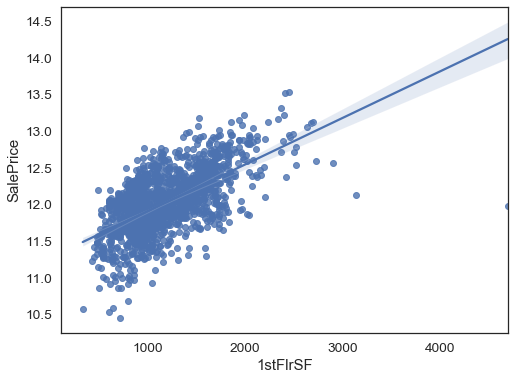

In [212]:
data = pd.concat([df_train['SalePrice'], df_train['1stFlrSF']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='1stFlrSF', y="SalePrice", data=data)

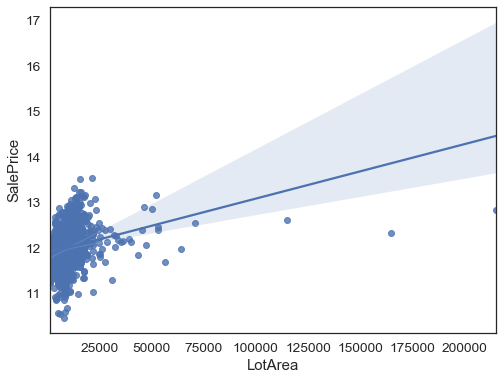

In [213]:
data = pd.concat([df_train['SalePrice'], df_train['LotArea']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='LotArea', y="SalePrice", data=data)

##### 범주형 데이터를 확인해보자

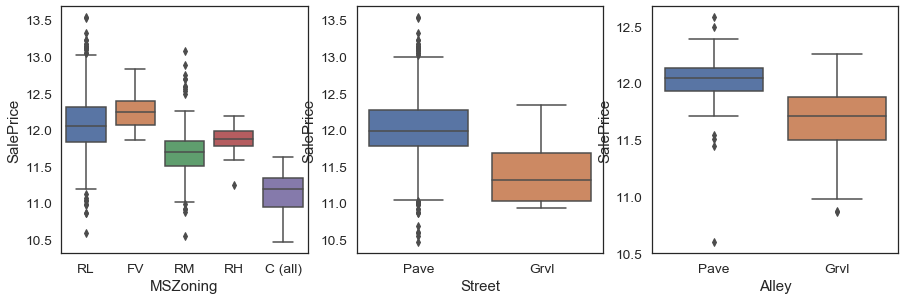

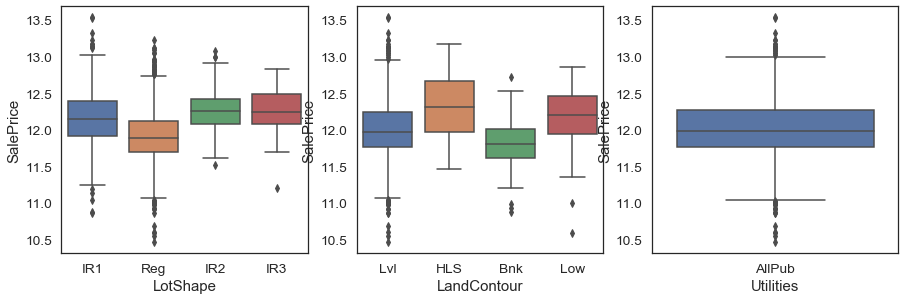

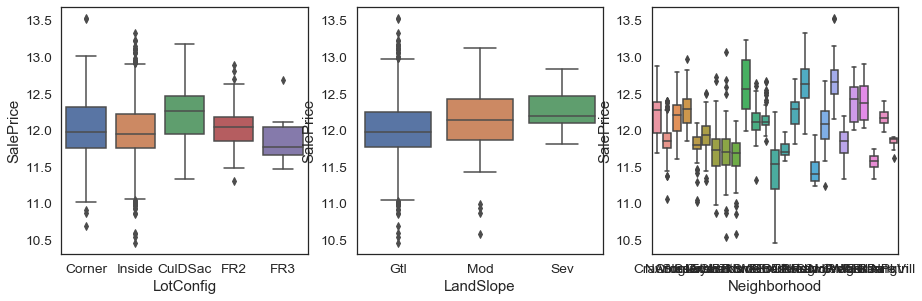

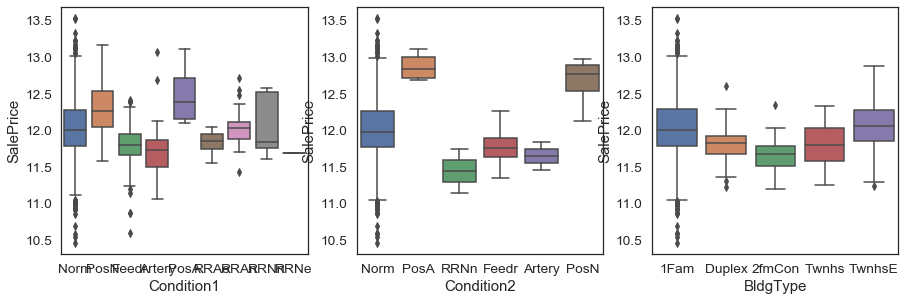

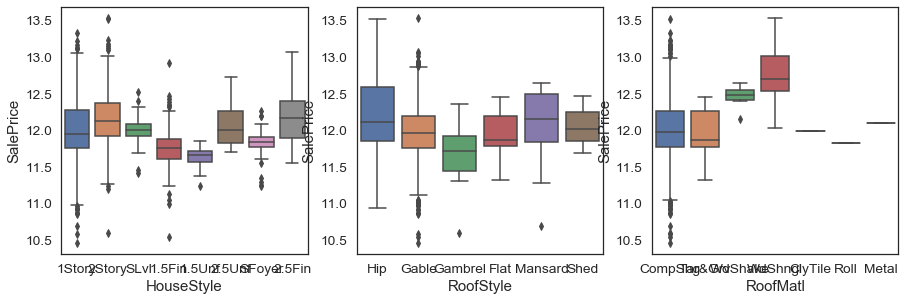

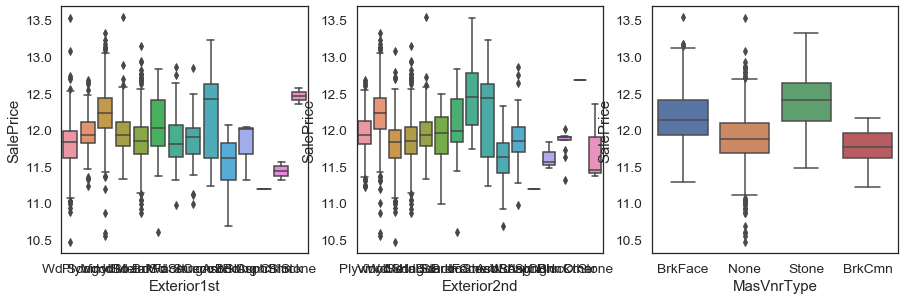

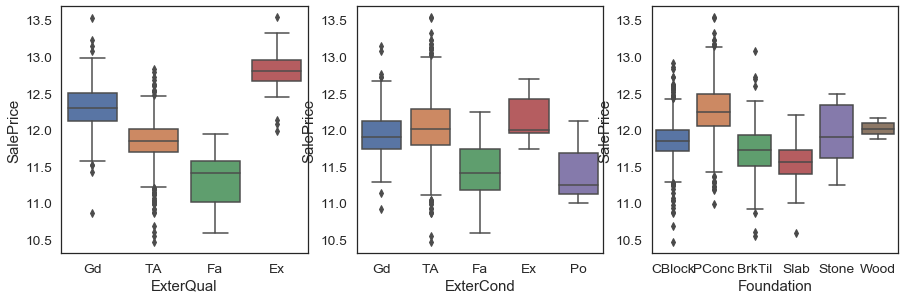

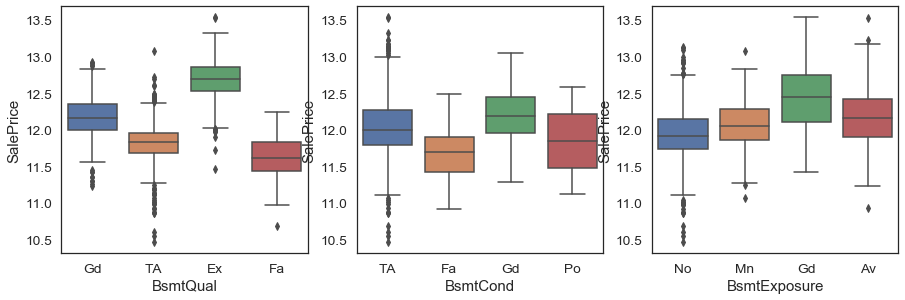

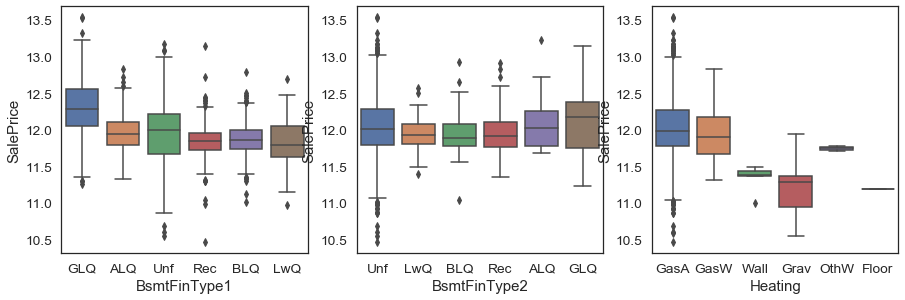

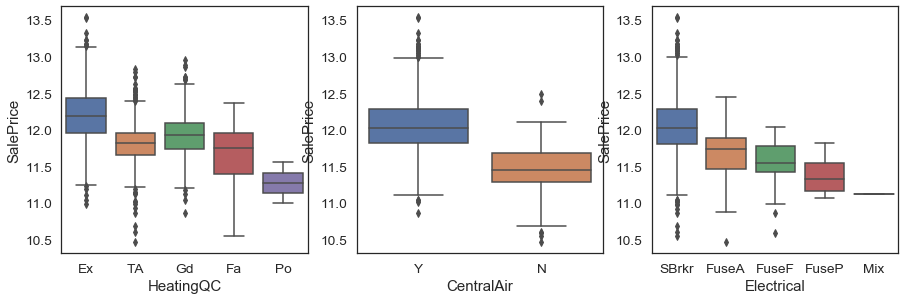

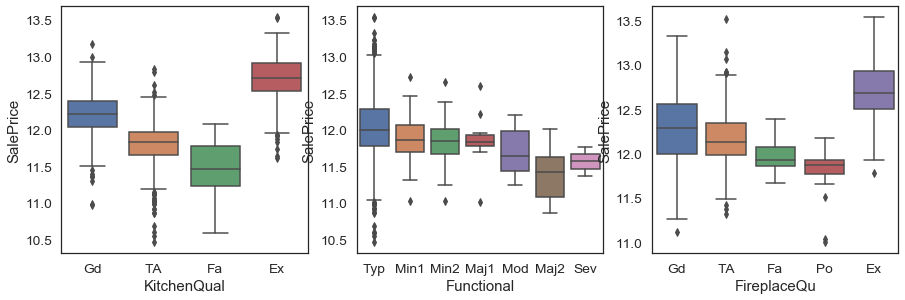

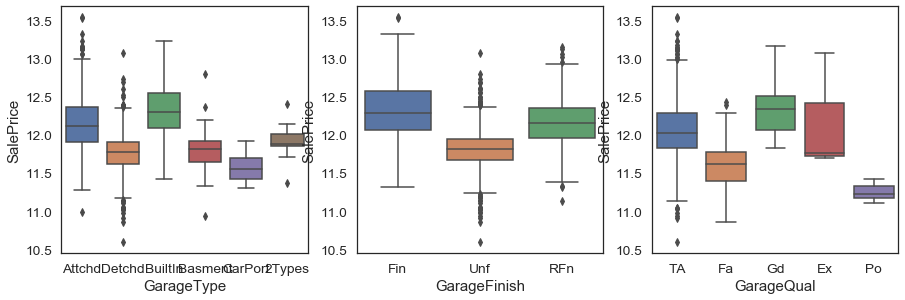

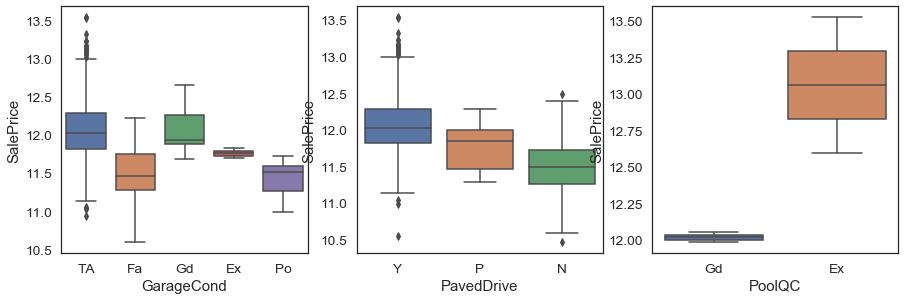

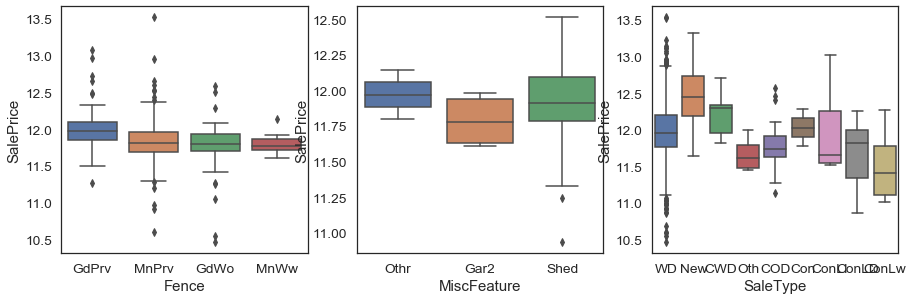

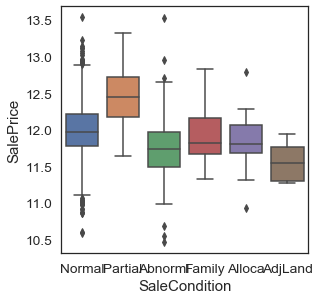

In [214]:
categorical_features = df_train.select_dtypes(include = ["object"]).columns #카테고리형인 특성값(이름)을 변수에 담아줌

ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(df_train[categorical_features]):
    if ix <= 3:
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.boxplot(data=df_train, x=c, y='SalePrice', ax=ax2)
            
    ix = ix + 1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1

타켓값에 영향을 크게 미치는 변수들을 확인함 ==> PoolQC, KitchenQual, Condition1 and 2, Neighborhood, Alley, MSZoning

##### 수치형데이터를 확인해보자

In [215]:
#!pip uninstall statsmodels

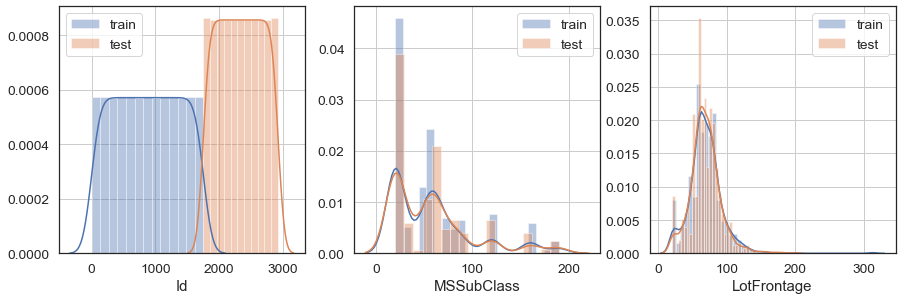

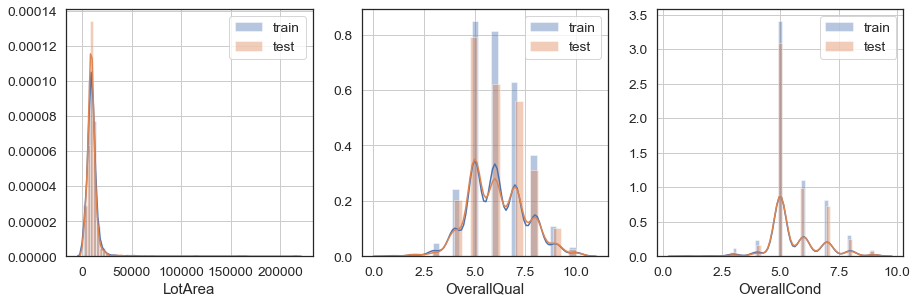

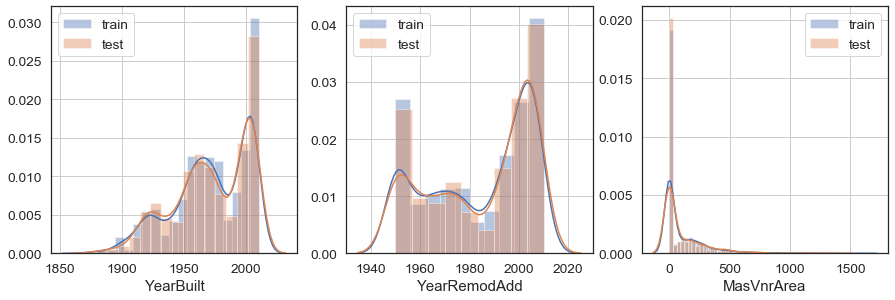

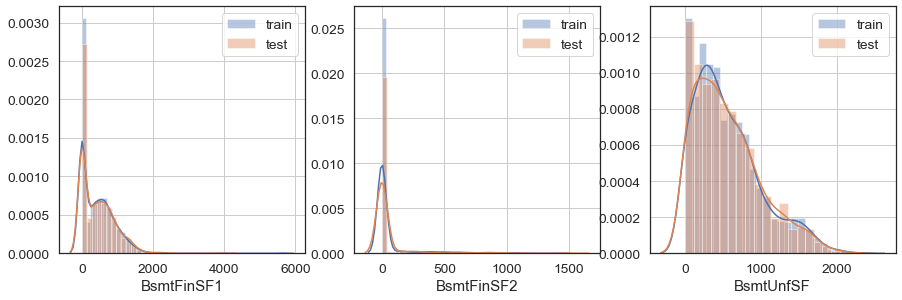

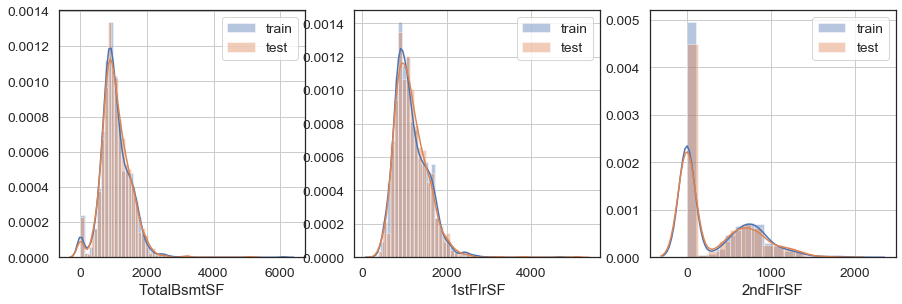

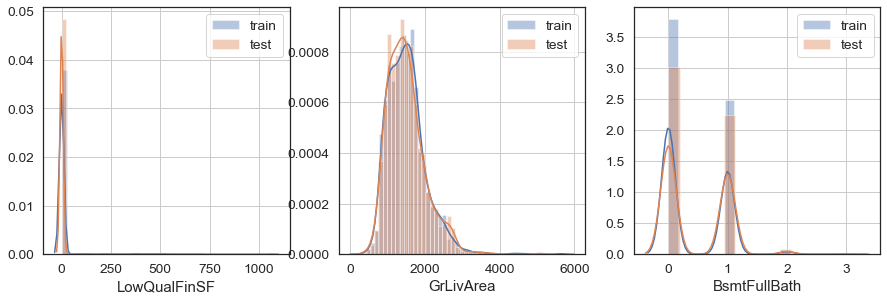

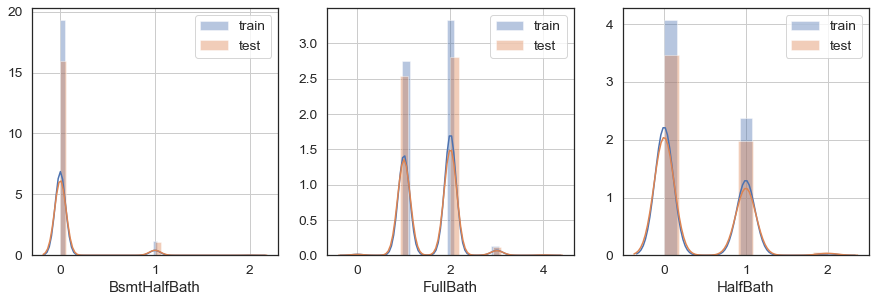

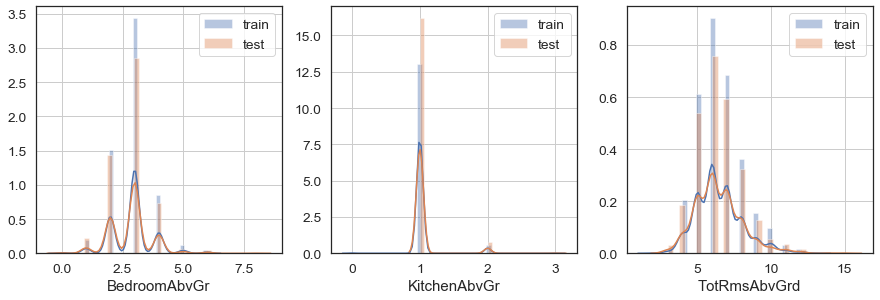

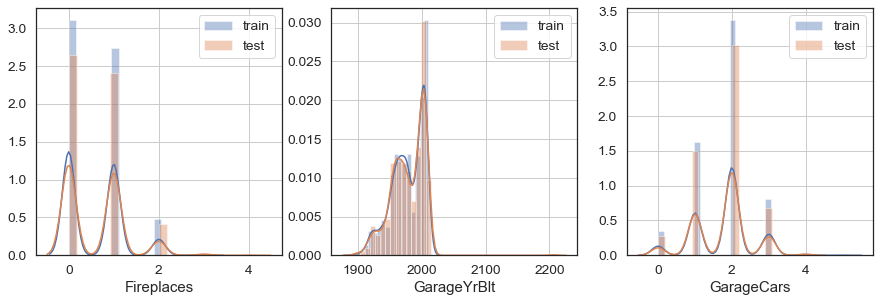

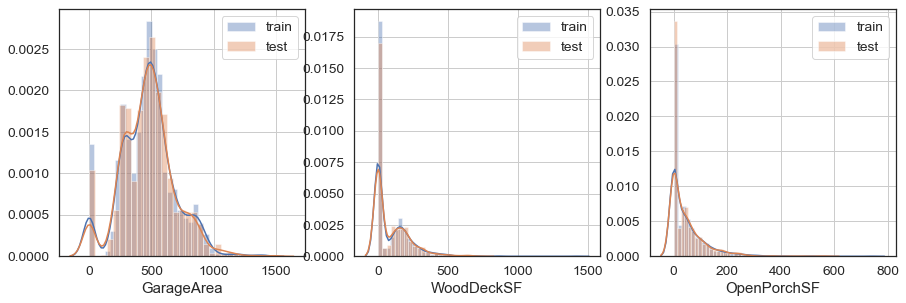

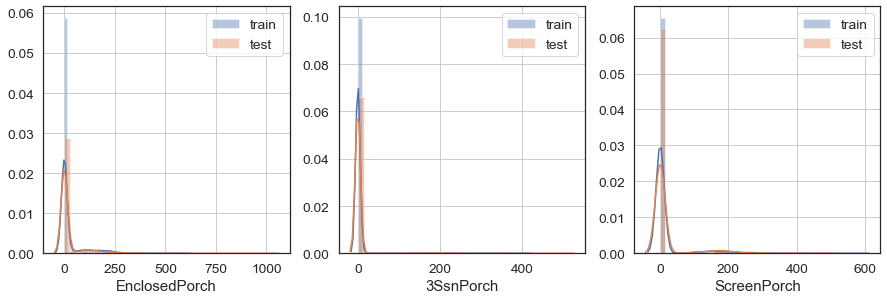

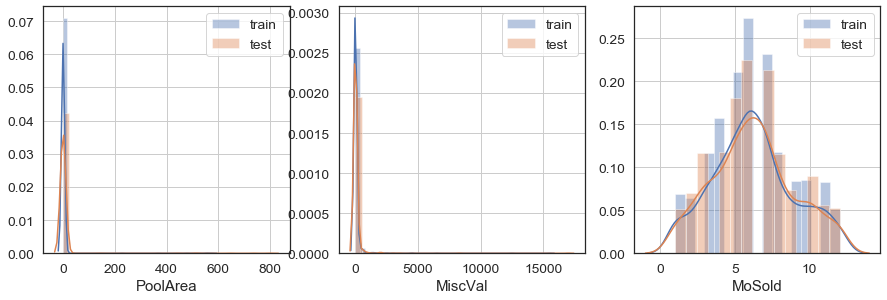

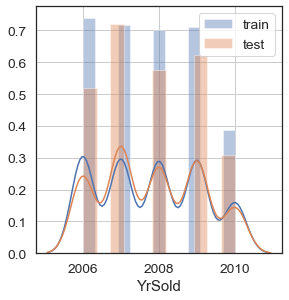

In [216]:
Numeric = df_train.copy()
del Numeric['SalePrice']
Numeric_columns = Numeric.select_dtypes(include = ["int64","float64"]).columns

ix = 1
fig = plt.figure(figsize = (15,10))
for c in list(Numeric_columns):
    if ix <= 3:
            ax2 = fig.add_subplot(2,3,ix+3)
            sns.distplot(df_train[c].dropna())
            sns.distplot(df_test[c].dropna())
            plt.legend(['train', 'test'])
            plt.grid()            
    ix = ix +1
    if ix == 4: 
        fig = plt.figure(figsize = (15,10))
        ix =1
del Numeric

# 2.전처리

### 1)이상치(outliers) 해결

In [217]:
# 이상치값 지우기..
df_train = df_train[df_train['Id']!= 692][df_train['Id']!=1183]

# 위에서 찾았던 이상치 값들 drop 
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<12.5)].index)
df_train = df_train.drop(df_train[(df_train['LotArea']>150000)].index)
df_train = df_train.drop(df_train[(df_train['GarageArea']>1200) & (df_train['SalePrice']<12.5)].index)

### 2)결측치 (Missing values)

In [218]:
# .isnull() -->T, F로 null값 체크
# .isnull().sum() -->널값인 곳 더해줌(해당특성의 비어있는 샘플 갯수만큼 덧셈)
# .isnull().sum().sort_values(ascending=False) 내림차순으로 정렬
# .isnull().count() --> 전부카운트한것 --> 즉 1751(아래에선 훈련데이터 셋만큼 카운트)

In [219]:
# 누락된 데이터
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

Text(0.5, 1.0, 'Total Missing Value (%)')

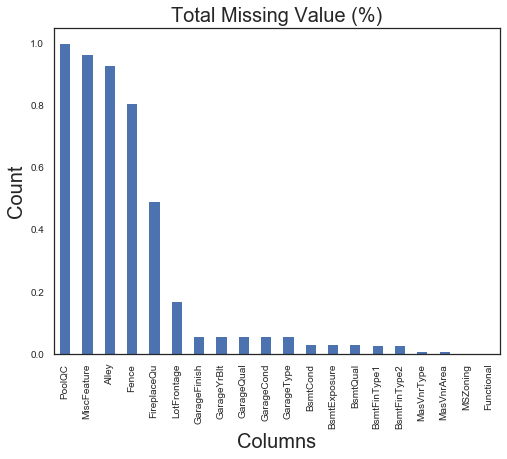

In [220]:
#histogram을 사용한 분포도 확인
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

- 왜 누락된 값이 있는가?
- 이 누락된 곳을 어떻게 할 것인가?

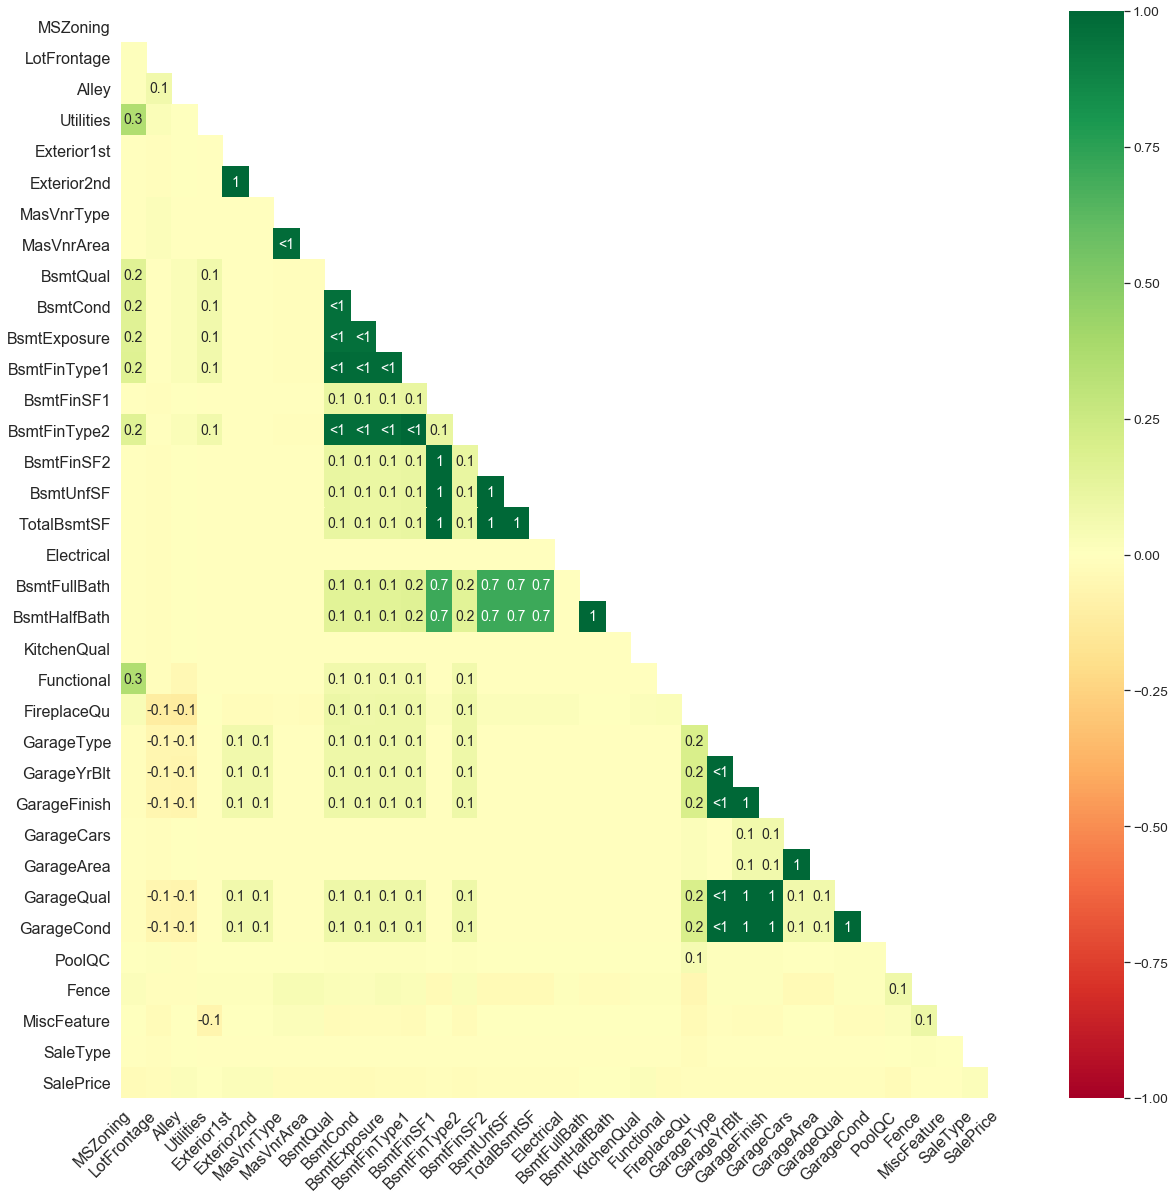

In [221]:
#!pip install missingno
import missingno as msno
len_train = df_train.shape[0]
y_reg = df_train['SalePrice']
Id = df_test['Id']
df_all = pd.concat([df_train,df_test])  #concat으로 훈련데이터와 테스트데이터 합쳐줌 ==> 왜? 두 셋에 동일한 특성공학을 적용해 주기위해
del df_all['Id']
missingdata_df = df_all.columns[df_all.isnull().any()].tolist()
msno.heatmap(df_all[missingdata_df], figsize=(20,20), cmap='RdYlGn')

- 결측치간 상관관계가 있는 일부 변수 존재 (e.g., Bsmt-, Garage- ..) 

In [222]:
df_all['Utilities'].unique()

array(['AllPub', nan, 'NoSeWa'], dtype=object)

In [223]:
df_all['Utilities'].describe()   #하나의 값의 빈도수가 굉장히 높음(AllPub_2907)(NoSeWa_1)

count       2908
unique         2
top       AllPub
freq        2907
Name: Utilities, dtype: object

In [224]:
del df_all['Utilities']          #그래서 Utilities열 지워줌

##### 결측치 --> None으로 채워주자
- 이는 BsmtCond의 NA와 같은 의미 ("지하실이 없다"와 같이 존재X)

BsmtCond: 지하실의 전반적인 상태 평가

- Ex Ex Experience
- Gd Good
- TA 일반 - 약간의 습기가 허용됨
- 공정 - 습기 또는 일부 균열 또는 정착
- Po 불량 - 심한 균열, 정착 또는 습기
- NA No 지하실

In [225]:
df_all["PoolQC"] = df_all["PoolQC"].fillna("None")               #수영장품질
df_all["MiscFeature"] = df_all["MiscFeature"].fillna("None")     #기타 범주에 포함되지 않은 기타 기능
df_all["Alley"] = df_all["Alley"].fillna("None")                 #골목길 접근 유형: 골목길
df_all["Fence"] = df_all["Fence"].fillna("None")                 #울타리 : 울타리 품질
df_all["FireplaceQu"] = df_all["FireplaceQu"].fillna("None")     #벽난로 품질
df_all['BsmtQual'] = df_all['BsmtQual'].fillna('None')           #지하실 높이를 등급화
df_all['BsmtCond'] = df_all['BsmtCond'].fillna('None')           #지하실의 일반적인 상태로 본 등급
df_all['BsmtExposure'] = df_all['BsmtExposure'].fillna('None')   #벽이나 정원의 도보 적합도 수준
df_all['BsmtFinType1'] = df_all['BsmtFinType1'].fillna('None')   #지하실 완공 면적의 등급
df_all['BsmtFinType2'] = df_all['BsmtFinType2'].fillna('None')   #multiple type일 경우의 지하실 완공 면적 등급
df_all['GarageType'] = df_all['GarageType'].fillna('None')       #창고 위치에 따른 타입
df_all['GarageFinish'] = df_all['GarageFinish'].fillna('None')   #창고 인테리어 완료
df_all['GarageQual'] = df_all['GarageQual'].fillna('None')       #창고 품질
df_all['GarageCond'] = df_all['GarageCond'].fillna('None')       #창고 상태

##### 결측치 --> 0으로 채워주자
- BsmtFinSF1의 0처럼 채워주기 ("피트가 0인 것은 존재하지 않는 것")

BsmtFinSF1: 타입 1 마감 평방피트

In [226]:
#여기에서 0
df_all['BsmtFinSF1'] = df_all['BsmtFinSF1'].fillna(0)       #크기가 1 평방 미터인 지하실
df_all['BsmtFinSF2'] = df_all['BsmtFinSF2'].fillna(0)       #크기가 2 평방 미터인 지하실
df_all['BsmtUnfSF'] = df_all['BsmtUnfSF'].fillna(0)         #면적이 평방 미터로 측정이 안되는 지하실
df_all['TotalBsmtSF'] = df_all['TotalBsmtSF'].fillna(0)     #지하실의 총 평방 미터
df_all['BsmtFullBath'] = df_all['BsmtFullBath'].fillna(0)   #full bathrooms(욕조가 완비된 욕실)을 갖춘 지하실
df_all['BsmtHalfBath'] = df_all['BsmtHalfBath'].fillna(0)   #half bathrooms을 갖춘 지하실
df_all['MasVnrArea'] = df_all['MasVnrArea'].fillna(0)       #평방 미터 안의 석조 베니어 영역
df_all['GarageYrBlt'] = df_all['GarageYrBlt'].fillna(0)     #창고 건축년도
df_all['GarageCars'] = df_all['GarageCars'].fillna(0)       #창고내 차 대수
df_all['GarageArea'] = df_all['GarageArea'].fillna(0)       #창고 면적

##### 결측치 --> 최빈값(빈도수가 가장 높은 값, mode)으로 채워주기
- 대표적인 방법에 해당하나 한쪽으로 편향 될 수 있음 (e.g., 여성남성 두 데이터가 있을때, 남성의 값이 최빈값인 경우)

In [227]:
df_all['MSZoning'] = df_all['MSZoning'].fillna(df_all['MSZoning'].mode()[0])            #용도별 지구 식별자
df_all['Exterior1st'] = df_all['Exterior1st'].fillna(df_all['Exterior1st'].mode()[0])   #건물 외장 형태
df_all['Exterior2nd'] = df_all['Exterior2nd'].fillna(df_all['Exterior2nd'].mode()[0])   #건물 외장 형태(2개 이상의 형태를 쓴 경우)
df_all['MasVnrType'] = df_all['MasVnrType'].fillna(df_all['MasVnrType'].mode()[0])      #석조 베니어 타입
df_all['Electrical'] = df_all['Electrical'].fillna(df_all['Electrical'].mode()[0])      #전기 시스템
df_all['KitchenQual'] = df_all['KitchenQual'].fillna(df_all['KitchenQual'].mode()[0])   #주방 품질
df_all['Functional'] = df_all['Functional'].fillna(df_all['Functional'].mode()[0])      #홈 기능
df_all['SaleType'] = df_all['SaleType'].fillna(df_all['SaleType'].mode()[0])            #판매 방식

##### LotFrontage의 결측치 -> 중앙값(median)으로 채워주기
- 이웃간 LotFrontage(샘플(집)에 연결된 거리의 선형 피트)가 이웃간 유사하다는 가정이 전제 됨
- 이를 확인해보면? BrkSide와 CollgCr로 확인해보았을 때 25%~75%까지 비슷함을 볼 수 있음

In [228]:
df_all[df_all['Neighborhood']=='BrkSide']['LotFrontage'].describe()

count     95.000000
mean      55.789474
std       12.722818
min       50.000000
25%       50.000000
50%       51.000000
75%       58.500000
max      144.000000
Name: LotFrontage, dtype: float64

In [229]:
df_all[df_all['Neighborhood']=='CollgCr']['LotFrontage'].describe()

count    219.000000
mean      71.251142
std       15.926607
min       36.000000
25%       64.000000
50%       70.000000
75%       78.000000
max      133.000000
Name: LotFrontage, dtype: float64

In [230]:
df_all["LotFrontage"] = df_all.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median())) 
#함수를 한 줄로 쓰게 해주는 (lambda 인자: 표현식)

### 해결되지 않은 결측치가 존재하는지 확인

Text(0.5, 1.0, 'Total Missing Value (%)')

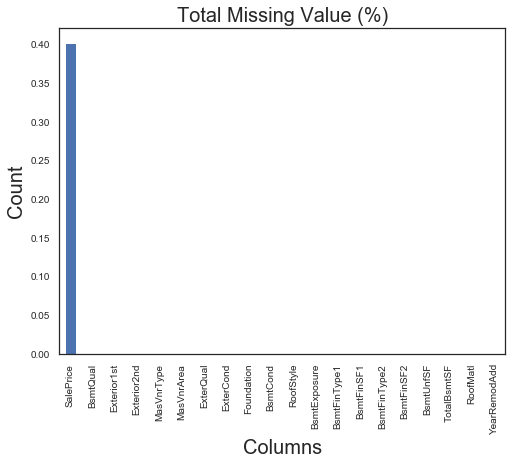

In [231]:
# 누락된 데이터
total = df_all.isnull().sum().sort_values(ascending=False)
percent = (df_all.isnull().sum()/df_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#histogram을 사용한 분포도 확인
#missing_data = missing_data.head(20)
percent_data = percent.head(20)
percent_data.plot(kind="bar", figsize = (8,6), fontsize = 10)
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("Count", fontsize = 20)
plt.title("Total Missing Value (%)", fontsize = 20)

결측치 --> 없음!

### 3) 객체 인코딩 : one-hot, Label, Frequency
- 컴퓨터에서 읽을 수 있도록 객체 인코딩 필요함

#### (1) one-hot encoding 
 *e.g.,*
 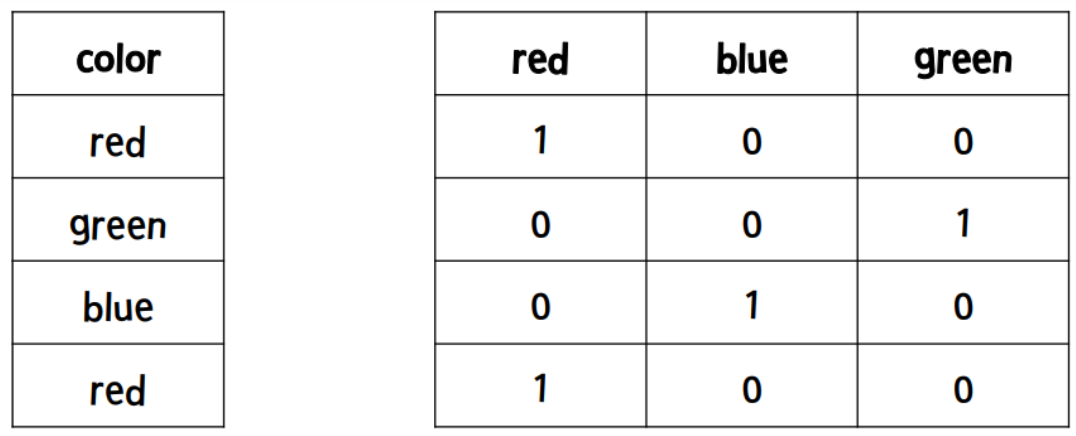 

MSSubClass, OverallCond 특성을 범주형(categorical)으로 인코딩
- MSSubClass : 분양에 관여하는 주거의 유형을 식별
- OverallCond: 주택의 전반적인 상태 평가

In [232]:
df_all['MSSubClass'] = df_all['MSSubClass'].apply(str)

df_all['OverallCond'] = df_all['OverallCond'].astype(str)

In [233]:
categorical_features = df_all.select_dtypes(include = ["object"]).columns  #범주형 특성들 변수에 담아줌
numerical_features = df_all.select_dtypes(exclude = ["object"]).columns    #범주형 아닌 특성들 담아줌
numerical_features = numerical_features.drop("SalePrice")   #수치형의 타겟값 없애줌

print("수치형 샘플수 : " + str(len(numerical_features)))
print("범주형 샘플수 : " + str(len(categorical_features)))

수치형 샘플수 : 34
범주형 샘플수 : 44


In [234]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoding = df_all.copy()
one_hot_encoding = pd.get_dummies(one_hot_encoding)
#len_train
one_hot_encoding.iloc[:,36:50].head()

,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [235]:
del one_hot_encoding;

#### (2) Label Encoding
*e.g.,*
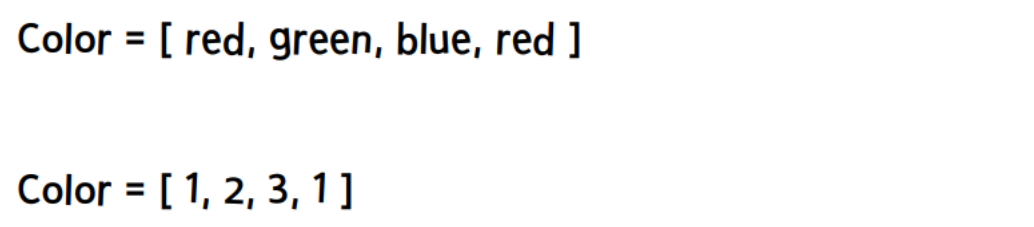

In [236]:
label_encoding = df_all.copy()
for i in categorical_features:
    label_encoding[i], indexer = pd.factorize(label_encoding[i])
label_encoding.iloc[:,20:30].head()

,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond
0,0,0,0,0,260.0,0,0,0,0,0
1,0,1,0,1,0.0,1,1,0,1,0
2,0,2,1,0,99.0,0,1,1,0,0
3,0,0,2,1,0.0,0,1,1,0,0
4,0,1,0,1,0.0,1,1,0,1,0


In [237]:
del label_encoding;

#### (3) Frequency Encoding
*e.g.,*
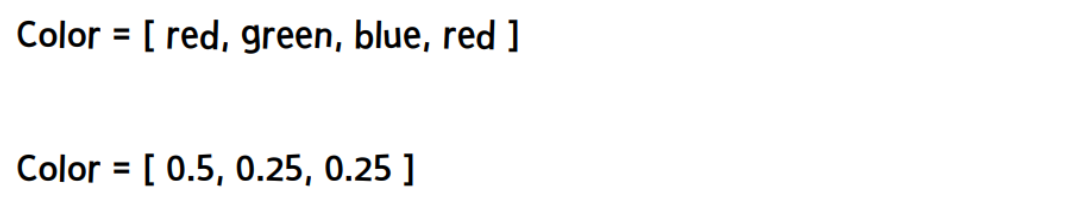

In [238]:
frequency_encoding_all = df_all.copy()
    
def frequency_encoding(frame, col):
    freq_encoding = frame.groupby([col]).size()/frame.shape[0] 
    freq_encoding = freq_encoding.reset_index().rename(columns={0:'{}_Frequency'.format(col)})
    return frame.merge(freq_encoding, on=col, how='left')

for col in categorical_features:
    frequency_encoding_all = frequency_encoding(frequency_encoding_all, col)
frequency_encoding_all = frequency_encoding_all.drop(categorical_features,axis=1, inplace=False)
frequency_encoding_all.iloc[:,20:30].head()

,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch
0,5,1,1988.0,2.0,540.0,292,44,0,182,0
1,5,0,1979.0,2.0,576.0,0,312,40,0,0
2,6,1,2002.0,2.0,530.0,192,36,0,0,0
3,6,1,1997.0,1.0,434.0,0,382,0,0,110
4,7,1,1968.0,2.0,440.0,0,96,180,0,0


In [239]:
del frequency_encoding_all

#### (4) 교차검증
- 모델의 성능을 판단하는 기준
![](https://github.com/choco9966/Team-EDA/blob/master/image/Cross%20validation.PNG?raw=true)

In [240]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#K-folds 검증
n_folds = 5   # LOOCV k = df_train.shape[0] 인 경우

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [244]:
one_hot_encoding = df_all.copy()
del one_hot_encoding['SalePrice']
one_hot_encoding = pd.get_dummies(one_hot_encoding)
one_hot_encoding_train = one_hot_encoding[:len_train]
one_hot_encoding_test = one_hot_encoding[len_train:]
del one_hot_encoding

import lightgbm as lgb

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                          bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  
score = rmsle_cv(model,one_hot_encoding_train)  
print("One-hot encoding(5-folds) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [245]:
#K-folds 검증 기능
n_folds = one_hot_encoding_train.shape[0] # LOOCV k = df_train.shape[0]인 경우

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [246]:
import lightgbm as lgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,  feature_fraction_seed=9, 
                          bagging_seed=9,  min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  
score = rmsle_cv(model,one_hot_encoding_train)  
print("One-hot encoding(LOOCV) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#K-folds 검증 기능
n_folds = 5 # LOOCV k = df_train.shape[0]인 경우

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

label_encoding = df_all.copy()
for i in categorical_features:
    label_encoding[i], indexer = pd.factorize(label_encoding[i])
    
del label_encoding['SalePrice']
label_encoding_train = label_encoding[:len_train]
label_encoding_test = label_encoding[len_train:]
del label_encoding


model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                          bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

score = rmsle_cv(model,label_encoding_train)  
print("Label encoding(5-folds) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
#K-folds 검증 기능
n_folds = label_encoding_train.shape[0] # LOOCV k = df_train.shape인 경우

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                          bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  
score = rmsle_cv(model,label_encoding_train)  
print("Label encoding(LOOCV) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#K-folds 검증 기능
n_folds = 5 # LOOCV k = df_train.shape[0]인 경우

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

frequency_encoding_all = df_all.copy()
    
def frequency_encoding(frame, col):
    freq_encoding = frame.groupby([col]).size()/frame.shape[0] 
    freq_encoding = freq_encoding.reset_index().rename(columns={0:'{}_Frequency'.format(col)})
    return frame.merge(freq_encoding, on=col, how='left')

for col in categorical_features:
    frequency_encoding_all = frequency_encoding(frequency_encoding_all, col)
frequency_encoding_all = frequency_encoding_all.drop(categorical_features,axis=1, inplace=False)

del frequency_encoding_all['SalePrice']
frequency_encoding_train = frequency_encoding_all[:len_train]
frequency_encoding_test = frequency_encoding_all[len_train:]
del frequency_encoding_all


model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                          bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

score = rmsle_cv(model,frequency_encoding_train)  
print("Frequency encoding(5-folds) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
#K-folds 검증 기능
n_folds = frequency_encoding_train.shape[0] # if LOOCV k = df_train.shape[0]

def rmsle_cv(model,df):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(df.values)
    rmse= np.sqrt(-cross_val_score(model, df.values, y_reg, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin = 55, 
                          bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319, feature_fraction_seed=9, 
                          bagging_seed=9, min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  
score = rmsle_cv(model,frequency_encoding_train)  
print("Label encoding(LOOCV) LGBM 점수: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

|    | One-hot encoding(5-fold) | Label encoding(5-fold) | Frequency encoding(5-fold) |  One-hot encoding(LOOCV) | Label encoding(LOOCV) | Frequency encoding(LOOCV)|
|----|------------------|----------------|--------------------|---------------|--------------|--------------|
| CV |0.0875 (0.0103)               |0.1169(0.0055)                |0.1169 (0.0056)                    |0.0793(0.0850)               | 0.0795 (0.0853)             | 0.0799 (0.0843)             |
| LB |                  |                |                    |               |              |              |

# 3.특성공학
### 1) 덧셈, 뺄셈, 곱셈, 나눗셈
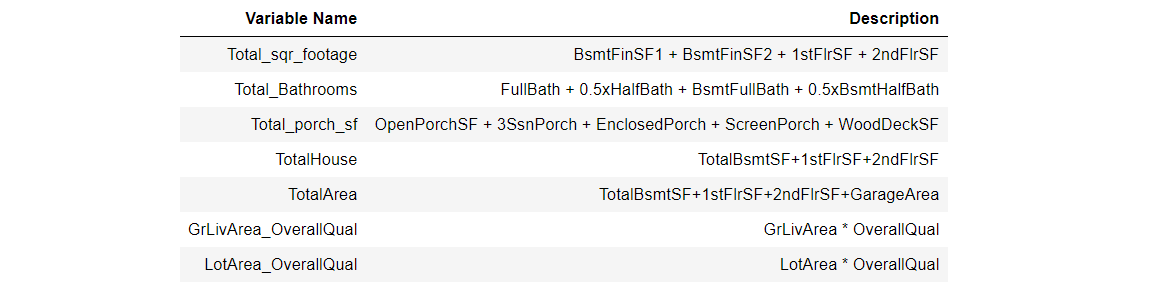

In [ ]:
one_hot_encoding = pd.concat([one_hot_encoding_train,one_hot_encoding_test])
one_hot_encoding['Total_sqr_footage'] = one_hot_encoding['BsmtFinSF1'] + one_hot_encoding['BsmtFinSF2'] + one_hot_encoding['1stFlrSF'] + one_hot_encoding['2ndFlrSF']
one_hot_encoding['Total_Bathrooms'] = one_hot_encoding['FullBath'] + one_hot_encoding['HalfBath'] + one_hot_encoding['BsmtFullBath'] + one_hot_encoding['BsmtHalfBath']
one_hot_encoding['Total_porch_sf'] = one_hot_encoding['OpenPorchSF'] + one_hot_encoding['3SsnPorch'] + one_hot_encoding['EnclosedPorch'] + one_hot_encoding['ScreenPorch'] + one_hot_encoding['WoodDeckSF'] 
one_hot_encoding['TotalHouse'] = one_hot_encoding['TotalBsmtSF'] + one_hot_encoding['1stFlrSF'] + one_hot_encoding['2ndFlrSF']
one_hot_encoding['TotalArea'] = one_hot_encoding['TotalBsmtSF'] + one_hot_encoding['1stFlrSF'] + one_hot_encoding['2ndFlrSF'] + one_hot_encoding["GarageArea"]
one_hot_encoding['GrLivArea_OverallQual'] = one_hot_encoding['GrLivArea'] * one_hot_encoding['OverallQual']
one_hot_encoding['LotArea_OverallQual'] = one_hot_encoding['LotArea'] * one_hot_encoding['OverallQual']

### 2) 통계변수 (최솟값, 최댓값, 평균값, 표준값, 왜도, 첨도 등..)
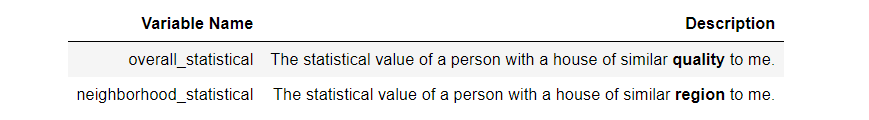

In [ ]:
#one_hot_encoding['SalePrice'] = y_reg
#agg = one_hot_encoding.groupby(['OverallQual'])['SalePrice'].agg('mean').reset_index()
#one_hot_encoding = one_hot_encoding.merge(agg, suffixes=["", "_mean"], how='left', on=['OverallQual'])
#agg = one_hot_encoding.groupby(['neighborhood'])['SalePrice'].agg('mean').reset_index()
#one_hot_encoding = one_hot_encoding.merge(agg, suffixes=["", "_mean"], how='left', on=['OverallQual'])

인코딩 전 수행시, score가 하락하는 문제점 발생

### 3) 범주형 데이터만들기 
- 존재한다면 1
- 미존재시 0
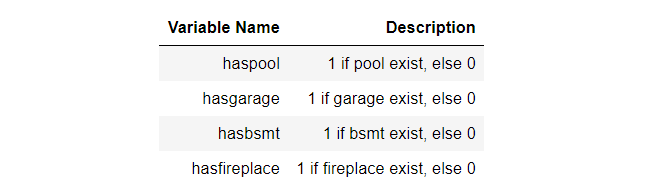

In [ ]:
one_hot_encoding['haspool'] = one_hot_encoding['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
one_hot_encoding['hasgarage'] = one_hot_encoding['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
one_hot_encoding['hasbsmt'] = one_hot_encoding['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
one_hot_encoding['hasfireplace'] = one_hot_encoding['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### 4) 정규화

In [ ]:
from scipy.stats import skew

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in one_hot_encoding.columns:
    if one_hot_encoding[i].dtype in numeric_dtypes: 
        numerics2.append(i)

skew_features = one_hot_encoding[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews.head()

In [ ]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skew_features[skew_features > 0.5]
high_skew = high_skew
skew_index = high_skew.index

for i in skew_index:
    one_hot_encoding[i]= boxcox1p(one_hot_encoding[i], boxcox_normmax(one_hot_encoding[i]+1))

        
skew_features2 = one_hot_encoding[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2.head()

# 4.모델링
### 1) Ridge

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

one_hot_encoding_train = one_hot_encoding[:len_train]
one_hot_encoding_test = one_hot_encoding[len_train:]
del one_hot_encoding

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, one_hot_encoding_train, y_reg, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(one_hot_encoding_train, y_reg)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)
    
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

-> alpha의 정확도를 더 확인해보자!

In [ ]:
alphas_alt = [9,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10,10.1,10.2]

ridge_model2 = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv=kfolds)).fit(one_hot_encoding_train, y_reg)

print("Ridge 평균제곱근편차(RMSE) : ",cv_rmse(ridge_model2).mean())

In [ ]:
print("Best of alpha(ridge model) :" ,ridge_model2.steps[1][1].alpha_)

In [ ]:
ridge_coef = pd.DataFrame(np.round_(ridge_model2.steps[1][1].coef_, decimals=3), 
one_hot_encoding_test.columns, columns = ["penalized_regression_coefficients"])

ridge_coef = ridge_coef[ridge_coef['penalized_regression_coefficients'] != 0] # 0이 아닌 계수 제거!
ridge_coef = ridge_coef.sort_values(by = 'penalized_regression_coefficients', ascending = False) # 내림차순으로 정렬

fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= ridge_coef.index , data=ridge_coef)
ax.set(xlabel='Penalized Regression Coefficients')

In [ ]:
from sklearn.linear_model import LassoCV

alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


lasso_model2 = make_pipeline(RobustScaler(),
                             LassoCV(max_iter=1e7,
                                    alphas = alphas2,
                                    random_state = 42)).fit(one_hot_encoding_train, y_reg)
scores = lasso_model2.steps[1][1].mse_path_

plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [ ]:
print("Best of alpha in lasso model :",lasso_model2.steps[1][1].alpha_)
print("lasso rmse : ",cv_rmse(lasso_model2).mean())

In [ ]:
lasso_coef = pd.DataFrame(np.round_(lasso_model2.steps[1][1].coef_, decimals=3), 
one_hot_encoding_test.columns, columns = ["penalized_regression_coefficients"])
# remove the non-zero coefficients
lasso_coef = lasso_coef[lasso_coef['penalized_regression_coefficients'] != 0]
# sort the values from high to low
lasso_coef = lasso_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# plot the sorted dataframe
fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= lasso_coef.index , 
data=lasso_coef)
ax.set(xlabel='Penalized Regression Coefficients')

In [ ]:
from sklearn.linear_model import ElasticNetCV

e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(one_hot_encoding_train, y_reg)
print("elastic model rmse : ",cv_rmse(elastic_model3).mean())

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

xgb3 = XGBRegressor(learning_rate =0.01, n_estimators=5200, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,objective= 'reg:linear',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(one_hot_encoding_train, y_reg)
print("Xgboost model rmse : ",cv_rmse(xgb_fit).mean())

In [ ]:
model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=5000,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

lgbm_fit = model.fit(one_hot_encoding_train, y_reg)
print("lightgbm model rmse : ",cv_rmse(model).mean())

In [ ]:
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = one_hot_encoding_test.columns
feature_importance_df["importance"] = model.feature_importances_

In [ ]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(
    by="importance", ascending=False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
train_ridge_preds = ridge_model2.predict(one_hot_encoding_train)
train_lasso_preds = lasso_model2.predict(one_hot_encoding_train)
train_elastic_preds = elastic_model3.predict(one_hot_encoding_train)
train_xgb_preds = xgb_fit.predict(one_hot_encoding_train)
train_lgbm_preds = lgbm_fit.predict(one_hot_encoding_train)

stackX = pd.DataFrame(np.transpose(np.array([train_ridge_preds,train_lasso_preds,train_elastic_preds,train_xgb_preds,train_lgbm_preds])))

model = lgb.LGBMRegressor(objective='regression',num_leaves=5,  
                              learning_rate=0.01, n_estimators=4500,  
                              max_bin = 55, bagging_fraction = 0.8,  
                              bagging_freq = 5, feature_fraction = 0.2319,  
                              feature_fraction_seed=9, bagging_seed=9,  
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)  

stack_fit = model.fit(stackX, y_reg)

In [ ]:
print("lightgbm model rmse : ",cv_rmse(model).mean())

In [ ]:
test_ridge_preds   = ridge_model2.predict(one_hot_encoding_test)
test_lasso_preds   = lasso_model2.predict(one_hot_encoding_test)
test_elastic_preds = elastic_model3.predict(one_hot_encoding_test)
test_xgb_preds     = xgb_fit.predict(one_hot_encoding_test)
test_lgbm_preds    = lgbm_fit.predict(one_hot_encoding_test)

In [ ]:
### Weight Average
weight_average2 = 0.28018685*test_ridge_preds + 0.10355858*test_lasso_preds + 0.1161906*test_elastic_preds + 0.006204816*test_xgb_preds + 0.49386202*test_lgbm_preds
weight_average2 = np.expm1(weight_average2)
submission = pd.DataFrame({'Id': Id, 'SalePrice': weight_average2})
submission.to_csv('WeightAvg2.csv', index=False)